<a href="https://colab.research.google.com/github/Ofiregev/Final_Project-FetalCns/blob/main/Fetal_Cns_Final_reg_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import SubsetRandomSampler

In [187]:
# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [188]:
# Determine the available hardware (CPU or GPU) and set the PyTorch device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [189]:
# Read the list of images from the CSV file
train_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC.csv"
train_csv_df = pd.read_csv(train_csv)
print("CSV file loaded:")
print(train_csv_df.head())

CSV file loaded:
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81


In [190]:
# Compute min and max values of the head circumference
min_hc = train_csv_df['head circumference (mm)'].min()
max_hc = train_csv_df['head circumference (mm)'].max()
print(f"Min HC: {min_hc}, Max HC: {max_hc}")

Min HC: 44.3, Max HC: 346.4


In [191]:
# Normalize the labels in the dataset
train_csv_df['Normalized_HC'] = (train_csv_df['head circumference (mm)'] - min_hc) / (max_hc - min_hc)
output_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC_no_index.csv"
train_csv_df.to_csv(output_csv, index=False)
print("Normalized CSV file saved.")
print(train_csv_df.head())

Normalized CSV file saved.
     filename  pixel size(mm)  head circumference (mm)  Normalized_HC
0  000_HC.png        0.069136                    44.30       0.000000
1  001_HC.png        0.089659                    56.81       0.041410
2  002_HC.png        0.062033                    68.75       0.080933
3  003_HC.png        0.091291                    69.00       0.081761
4  004_HC.png        0.061240                    59.81       0.051341


In [192]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        label = self.data_frame.iloc[idx, 3]  # Assuming the fourth column is the normalized label
        return image, label

In [193]:
# Data Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images
])

In [194]:
# Create the dataset with the updated CSV
train_dataset = CustomDataset(csv_file=output_csv,
                              root_dir="/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/",
                              transform=transform)

In [195]:
# Create DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [196]:
# # Model Definition
class Model(nn.Module):
    def __init__(self, input_channels=1, input_size=64):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)  # Additional Convolutional Layer
        self.pool = nn.MaxPool2d(2, 2)
        conv_output_size = input_size // 2 // 2 // 2 // 2 // 2  # Adjusted for additional pooling layers
        self.fc1 = nn.Linear(512 * conv_output_size * conv_output_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)  # Increased Dropout Rate
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.pool(F.relu(self.conv5(x)))  # Additional Convolutional Layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [197]:
model = Model(input_channels=1, input_size=64)
model.to(device)

Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256,

In [198]:
# Define Training Parameters and Optimizer
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


In [199]:
# Plot Loss Function
def plot_loss(train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [200]:
# Training Function
def train(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
        scheduler.step()  # Step the scheduler

    plot_loss(train_losses, val_losses, epochs)

In [201]:
# Evaluation Function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_losses = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float().to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

    fold_avg_val_loss = np.mean(val_losses)
    return fold_avg_val_loss

Fold 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Train Loss: 0.0964, Validation Loss: 0.0394


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 2, Train Loss: 0.0535, Validation Loss: 0.0383
Epoch 3, Train Loss: 0.0508, Validation Loss: 0.0525
Epoch 4, Train Loss: 0.0368, Validation Loss: 0.0285
Epoch 5, Train Loss: 0.0369, Validation Loss: 0.0270
Epoch 6, Train Loss: 0.0381, Validation Loss: 0.0298


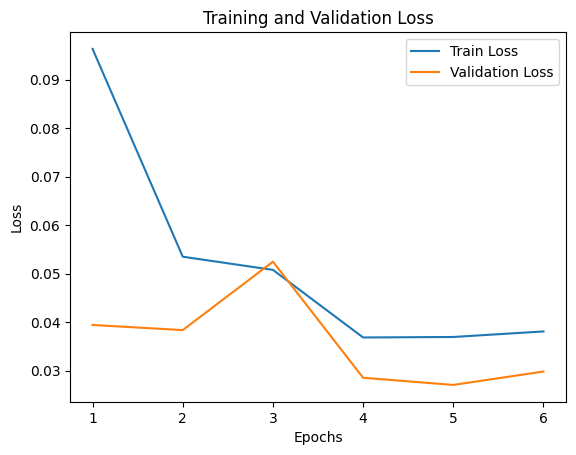

Fold 1 Validation Loss: 0.0296
Fold 2
Epoch 1, Train Loss: 0.1205, Validation Loss: 0.1100
Epoch 2, Train Loss: 0.0498, Validation Loss: 0.0425
Epoch 3, Train Loss: 0.0404, Validation Loss: 0.0344
Epoch 4, Train Loss: 0.0345, Validation Loss: 0.0331
Epoch 5, Train Loss: 0.0332, Validation Loss: 0.0316
Epoch 6, Train Loss: 0.0318, Validation Loss: 0.0341


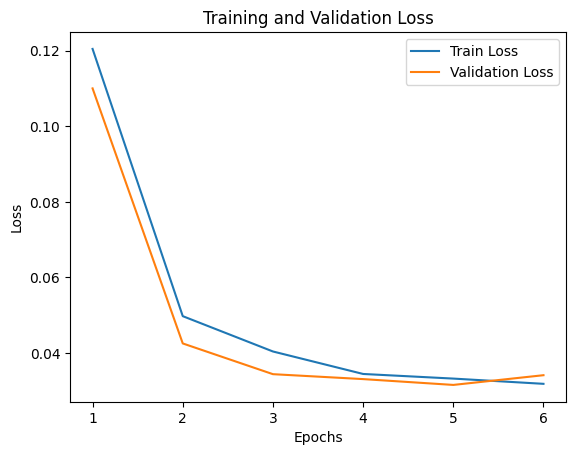

Fold 2 Validation Loss: 0.0330
Fold 3
Epoch 1, Train Loss: 0.1215, Validation Loss: 0.0320
Epoch 2, Train Loss: 0.0553, Validation Loss: 0.0339
Epoch 3, Train Loss: 0.0496, Validation Loss: 0.0305
Epoch 4, Train Loss: 0.0428, Validation Loss: 0.0253
Epoch 5, Train Loss: 0.0348, Validation Loss: 0.2423
Epoch 6, Train Loss: 0.0372, Validation Loss: 0.0311


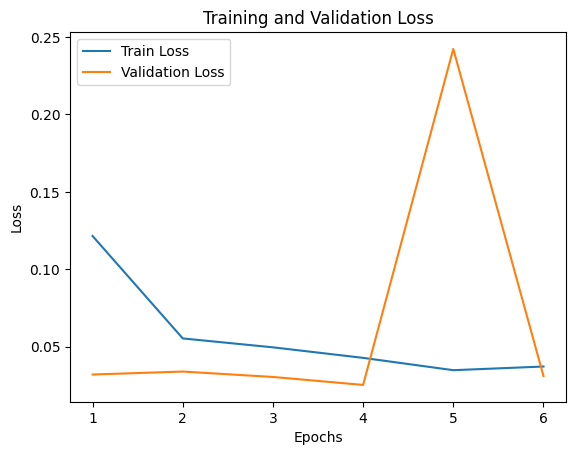

Fold 3 Validation Loss: 0.0310
Average Evaluation Metric: 0.0312


In [202]:
# K-Fold Cross-Validation
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)
evaluation_metrics = []
epochs = 6
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def reset_model(model_class, *args, **kwargs):
    model = model_class(*args, **kwargs)
    return model

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold_idx + 1}")
    print("=========")

    # Reset the model and optimizer
    model = reset_model(Model, input_channels=1, input_size=64).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Create data loaders using SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader_fold = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
    val_loader_fold = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

    # Train and evaluate
    train(model, train_loader_fold, val_loader_fold, optimizer, scheduler, criterion, epochs, device)
    fold_avg_val_loss = evaluate(model, val_loader_fold, criterion, device)
    evaluation_metrics.append(fold_avg_val_loss)

    print(f"Fold {fold_idx + 1} Validation Loss: {fold_avg_val_loss:.4f}")
    print("=========")

average_metric = np.mean(evaluation_metrics)
print(f"Average Evaluation Metric: {average_metric:.4f}")

In [203]:
# Save the trained model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
torch.save(model.state_dict(), model_path)
print("Model saved successfully!")

Model saved successfully!


In [204]:
# Load the trained model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
model = Model(input_channels=1, input_size=64)
model.load_state_dict(torch.load(model_path))
model.eval()

Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256,

In [205]:
def predict_head_circumference(image_path, model, min_hc, max_hc):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor.float())

    predicted_normalized_hc = output.item()
    predicted_hc = predicted_normalized_hc * (max_hc - min_hc) + min_hc  # De-normalize the prediction
    return predicted_hc


In [206]:
# Evaluate the model on the entire training set
num_images_to_test = len(train_csv_df)
indices = range(num_images_to_test)  # Generate a sequence of indices from 0 to num_images_to_test-1

# Initialize a list to store the absolute errors
absolute_errors = []
counter = 0
error_parameter = 5

# Open a file to write the results
with open("results.txt", "w") as file:
    # Loop through the selected images
    for idx in indices:
        image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", train_csv_df.iloc[idx, 0])
        ground_truth_circumference = train_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels

        # Call the function to predict head circumference from the image
        predicted_circumference = predict_head_circumference(image_path, model, min_hc, max_hc)

        # Calculate the absolute error and add it to the list
        absolute_error = abs(predicted_circumference - ground_truth_circumference)
        absolute_errors.append(absolute_error)

        if absolute_error < error_parameter:
            file.write(f"Image: {image_path}\n")
            file.write(f"Predicted Head Circumference: {predicted_circumference}\n")
            file.write(f"Ground Truth Head Circumference: {ground_truth_circumference}\n")
            file.write(f"Absolute Error: {absolute_error}\n")
            file.write("\n")
            file.write("****************************\n")
            counter += 1

    # Write the counter and percentage to the file
    file.write(f"Total Images with Error < {error_parameter}: {counter}\n")
    file.write(f"Percentage: {counter / num_images_to_test * 100:.2f}%\n")
    print(f"Total Images with Error < {error_parameter}: {counter}\n")
    print(f"Percentage: {counter / num_images_to_test * 100:.2f}%\n")


Total Images with Error < 5: 44

Percentage: 4.40%



In [207]:
# # Choose 10 random indices from the dataset
# num_images_to_test = 500
# random_indices = np.random.choice(len(train_csv_df), size=num_images_to_test, replace=False)

# # Initialize a list to store the absolute errors
# absolute_errors = []
# # Loop through the selected images
# for idx in random_indices:

#     image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", train_csv_df.iloc[idx, 0])
#     ground_truth_circumference = train_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels

#     # Call the function to predict head circumference from the image
#     predicted_circumference = predict_head_circumference(image_path, model, min_hc, max_hc)

#     # Calculate the absolute error and add it to the list
#     absolute_error = abs(predicted_circumference - ground_truth_circumference)
#     absolute_errors.append(absolute_error)


#     # Print the predicted and ground truth head circumferences
#     print("Image:", image_path)
#     print("Predicted Head Circumference:", predicted_circumference)
#     print("Ground Truth Head Circumference:", ground_truth_circumference)
#     print("Absolute Error:", absolute_error)
#     print("==============================================")

# # Calculate the average absolute error
# average_absolute_error = sum(absolute_errors) / len(absolute_errors)
# print("Average Absolute Error:", average_absolute_error)


In [208]:
# # # Path for the new image
# new_image_path = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/001_HC.png"
# # Call the function to predict head circumference from the new image
# predicted_circumference = predict_head_circumference(new_image_path, model, min_hc, max_hc)

# print("Predicted Head Circumference:", predicted_circumference)
